In [11]:
# -*- coding: utf-8 -*-
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from cStringIO import StringIO
import nltk.data
import re
import pyPdf


def pdf_to_text(pdfname, all):
    with open(pdfname, 'rb') as fp:
        rsrcmgr = PDFResourceManager()
        retstr = StringIO()
        device = TextConverter(rsrcmgr, retstr, codec='utf-8', laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        page = set()
        if not all:
            pdf = pyPdf.PdfFileReader(fp)
            num_of_pages = pdf.getNumPages()
            page = set(range(num_of_pages - 1))
        for page in PDFPage.get_pages(fp, page):
            interpreter.process_page(page)

        text = retstr.getvalue()
        device.close()
        retstr.close()
    return text


def text_to_sentences(text):
    # nltk.download()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    # Function to split a review into parsed sentences. Returns a
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(text.decode('utf-8').strip())

    # 2. Loop over each sentence
    sentences = []
    for sentence in raw_sentences:
        # If a sentence is empty, skip it
        # if (re.match(ur'.*\b\s*Р\s*Е\s*Ш\s*И\s*Л\s*.*?', sentence, flags=re.UNICODE) or
        #         re.match(ur'.*?отказать.*?', sentence, flags=re.UNICODE)):
        #     break
        if len(sentence) > 0:
            # Otherwise, append a list of words to sentences
            sentences.append(sentence_to_wordlist(sentence))

    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences


def sentence_to_wordlist(sentence):
    sentence = re.sub(ur'[\W\d]+', u' ', sentence, flags=re.UNICODE)
    words = [word for word in sentence.lower().split() if len(word) > 2]
    return words


In [127]:
# -*- coding: utf-8 -*-
import os
# from parser import pdf_to_text, text_to_sentences, sentence_to_wordlist
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from gensim.models import word2vec


def makeFeatureVec(words, model, size=300):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((size,), dtype="float")

    nwords = 0.
    #
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords += 1.
            featureVec = np.add(featureVec, model[word])
    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(texts, model, size=300):
    # Given a set of texts (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    textFeatureVecs = np.zeros((len(texts), size), dtype="float")
    #
    # Loop through the reviews
    for text in texts:
        # Call the function (defined above) that makes average feature vectors
        textFeatureVecs[counter] = makeFeatureVec(text, model, size)
        #
        # Increment the counter
        counter += 1.
    return textFeatureVecs


def train_and_save_model(model_name, train_data, workers=4,
                         size=300, min_count=20,
                         window=10, sample=1e-3):
    sentences = []
    for text in train_data['text']:
        sentences += text_to_sentences(text)

    model = word2vec.Word2Vec(sentences, workers=workers,
                              size=size, min_count=min_count,
                              window=window, sample=sample)

    # If you don't plan to train the model any further, calling
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
    return model_name


def read_train_data(data_path):
    texts = []
    positive = data_path + '/positive/'
    print 'get data from folder ' + positive

    for filename in os.listdir(positive):
        text = pdf_to_text(os.path.join(positive, filename), False)
        texts.append([filename, text, 1])

    negative = data_path + '/negative/'
    print 'get data from folder ' + negative

    for filename in os.listdir(negative):
        text = pdf_to_text(os.path.join(negative, filename), False)
        texts.append([filename, text, 0])

    header = ['id', 'text', 'classification']
    train = pd.DataFrame(texts, columns=header)
    return train


def read_test_data(data_path):
    texts = []
    positive = data_path + '/positive/'
    print 'get test data from folder ' + positive
    i = 1
    for filename in os.listdir(positive):
        text = pdf_to_text(os.path.join(positive, filename), False)
        texts.append([filename, text, 1])

    negative = data_path + '/negative/'
    print 'get test data from folder ' + negative
    i = 1
    for filename in os.listdir(negative):
        text = pdf_to_text(os.path.join(negative, filename), False)
        texts.append([filename, text, 0])

    header = ['id', 'text', 'classification']
    test = pd.DataFrame(texts, columns=header)
    return test


def trainRandomForest(train_data, test_data, model, size=300):

    clean_train = []
    for text in train_data['text']:
        clean_train.append(sentence_to_wordlist(unicode(text, 'utf-8')))
    trainDataVecs = getAvgFeatureVecs(clean_train, model, size)

    clean_test = []
    for text in test_data['text']:
        clean_test.append(sentence_to_wordlist(unicode(text, 'utf-8')))
    testDataVecs = getAvgFeatureVecs(clean_test, model, size)


    # Fit a random forest to the training data, using 100 trees

    forest = RandomForestClassifier(n_estimators=100)

    print "Fitting a random forest to labeled training data..."
    forest = forest.fit(trainDataVecs, train_data['classification'])

    importances = forest.feature_importances_

    #
    # Test & extract results
    # result = forest.predict(testDataVecs)


        # Plot the feature importances of the forest
    # Write the test results
    print forest.score(testDataVecs, test_data['classification'])

    return forest



In [128]:
from sklearn.cross_validation import train_test_split

data = read_train_data('../data')
#     test_data = read_test_data('../data/test')
train_data = data.sample(frac=0.85)
test_data = data.loc[~data.index.isin(train_data.index)]
model_name = '300size_20min_count_without_last.model'
train_and_save_model(model_name, train_data, min_count=30)
model = word2vec.Word2Vec.load(model_name)

clean_train = []
for text in train_data['text']:
    clean_train.append(sentence_to_wordlist(unicode(text, 'utf-8')))
trainDataVecs = getAvgFeatureVecs(clean_train, model, 300)

clean_test = []
for text in test_data['text']:
    clean_test.append(sentence_to_wordlist(unicode(text, 'utf-8')))
testDataVecs = getAvgFeatureVecs(clean_test, model, 300)

forest = RandomForestClassifier(n_estimators=100)

print "Fitting a random forest to labeled training data..."
forest = forest.fit(trainDataVecs, train_data['classification'])

print forest.score(testDataVecs, test_data['classification'])

get data from folder ../data/positive/
get data from folder ../data/negative/
Fitting a random forest to labeled training data...
0.932584269663


In [142]:
predict_forest = forest.predict(testDataVecs)
import sklearn.metrics

sklearn.metrics.accuracy_score(predict_forest, test_data['classification'])

0.93258426966292129

In [167]:
fpr, tpr, _ = sklearn.metrics.roc_curve(test_data['classification'], forest.predict_proba(testDataVecs)[:, 1])

<IPython.core.display.Javascript object>


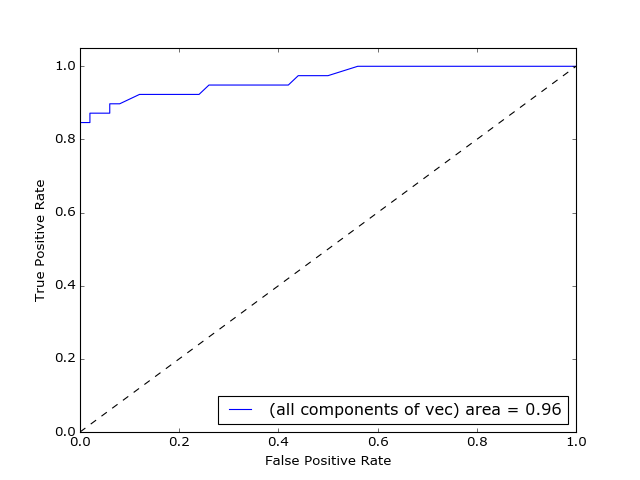

In [168]:
from matplotlib import pyplot as plt
%matplotlib nbagg
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='(all components of vec) area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()

In [165]:
importance = forest.feature_importances_
most_import_idx = np.argsort(-importance)[:10]
most_import_train_vec = trainDataVecs[:, most_import_idx]
forest_most_import = RandomForestClassifier(n_estimators=100)
forest_most_import = forest_most_import.fit(most_import_train_vec, train_data['classification'])
most_import_test_vec = testDataVecs[:, most_import_idx]
print forest_most_import.score(most_import_test_vec, test_data['classification'])

0.943820224719


In [166]:
# from matplotlib import pyplot as plt
# %matplotlib nbagg
fpr, tpr, _ = sklearn.metrics.roc_curve(test_data['classification'], forest_most_import.predict_proba(most_import_test_vec)[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='(10 components of vec) area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()

In [169]:
sklearn.metrics.confusion_matrix(test_data['classification'], predict_forest)

array([[49,  1],
       [ 5, 34]])

In [170]:
predict_most_import_test_vec = forest_most_import.predict(most_import_test_vec)
sklearn.metrics.confusion_matrix(test_data['classification'], predict_most_import_test_vec)

array([[49,  1],
       [ 4, 35]])

In [179]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf = clf.fit(trainDataVecs, train_data['classification'])
clf.score(testDataVecs, test_data['classification'])

0.8314606741573034

<IPython.core.display.Javascript object>


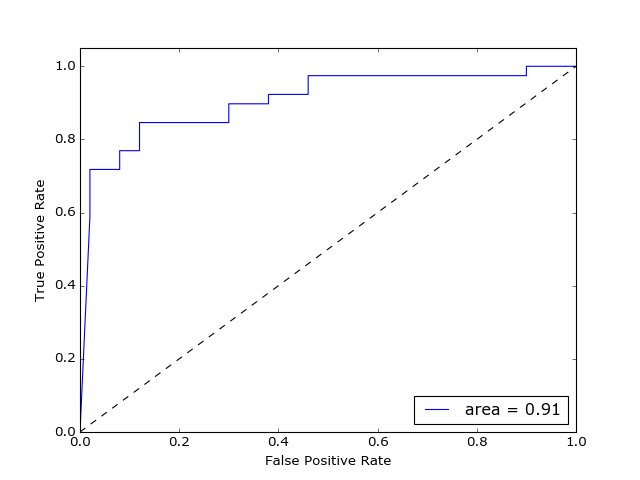

In [182]:
fpr, tpr, _ = sklearn.metrics.roc_curve(test_data['classification'], clf.predict_proba(testDataVecs)[:, 1])
from matplotlib import pyplot as plt
%matplotlib nbagg
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()

In [183]:
clf = BernoulliNB()
clf = clf.fit(most_import_train_vec, train_data['classification'])
clf.score(most_import_test_vec, test_data['classification'])

0.84269662921348309

<IPython.core.display.Javascript object>


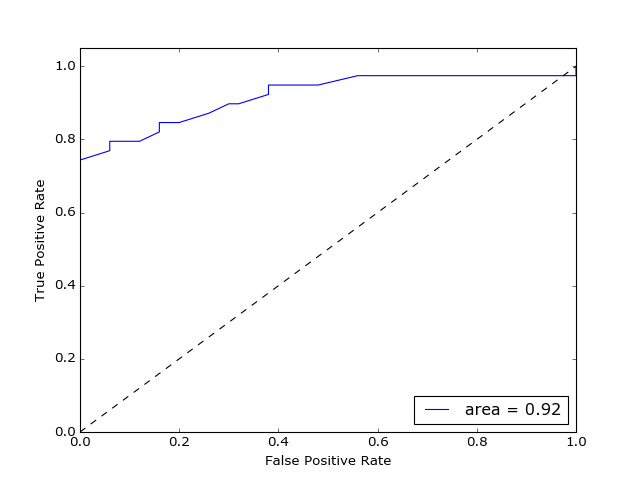

In [184]:
fpr, tpr, _ = sklearn.metrics.roc_curve(test_data['classification'], clf.predict_proba(most_import_test_vec)[:, 1])
from matplotlib import pyplot as plt
%matplotlib nbagg
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()

In [135]:
from sklearn.manifold import TSNE as tsne
plt.rc('font', family='verdana')
tsne_model = tsne()
vec = tsne_model.fit_transform(model.syn0)

<IPython.core.display.Javascript object>


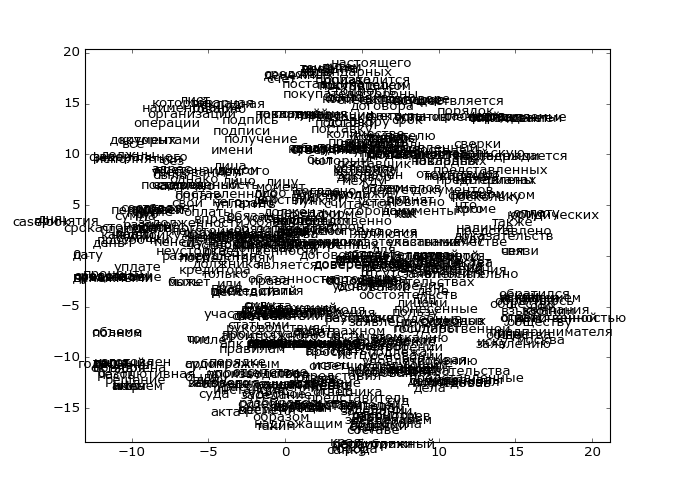

In [119]:
%matplotlib nbagg
xmin = np.amin(vec[:, 0])
xmax = np.amax(vec[:, 0])
ymin = np.amin(vec[:, 1])
ymax = np.amax(vec[:, 1])

plt.axis([xmin, xmax, ymin, ymax])

for index in xrange(500):
    plt.text(vec[index][0], vec[index][1], model.index2word[index], color='black')
            
plt.show()

In [ ]:
importance = forest.feature_importances_
most_import_idx = np.argsort(-importance)[:3]

most_import_train_vec = trainDataVecs[:, most_import_idx]
forest_most_import = RandomForestClassifier(n_estimators=100)
forest_most_import = forest_most_import.fit(most_import_train_vec, train_data['classification'])

idx_import_sort = np.lexsort((model.syn0[:, most_import_idx[2]], model.syn0[:, most_import_idx[1]]
                              , model.syn0[:, most_import_idx[0]]))

most_occuring_idx = idx_import_sort[:10]
most_occuring_word = []
for i in most_occuring_idx:
     most_occuring_word.append(model.index2word[i])


positive_data = train_data.loc[train_data["classification"] == 1]

negative_data = train_data.loc[train_data["classification"] == 0]

from collections import Counter
positive_text = []
for text in positive_data['text']:
    positive_text.extend(sentence_to_wordlist(unicode(text, 'utf-8')))
positive_word_count = Counter(positive_text)

negative_text = []
for text in negative_data['text']:
    negative_text.extend(sentence_to_wordlist(unicode(text, 'utf-8')))
negative_word_count = Counter(negative_text)

print "word \t\t positive_occurence \t\t negative_occurence"
print '=' * 70
for word in most_occuring_word:
    print ('%-25s %-30s %s' %  (word, str(positive_word_count[word]), str(negative_word_count[word])))

In [15]:
test()
print "all document"

get data from folder ../data/positive/
get data from folder ../data/negative/


KeyboardInterrupt: 

In [47]:
test()
print "half of test documents"

get data from folder ../data/positive/
get data from folder ../data/negative/
get test data from folder ../data/test/positive/
get test data from folder ../data/test/negative/
Fitting a random forest to labeled training data...
0.85
word 		 positive_occurence 		 negative_occurence
участии                   205                            243
чужими                    346                            204
пеней                     232                            12
судьей                    3                              147
денежными                 403                            226
годовых                   25                             7
судебном                  624                            651
средствами                411                            230
пользование               480                            216
расчете                   23                             7
half of test documents


In [51]:
test()
print "without last page"

get data from folder ../data/positive/
get data from folder ../data/negative/
get test data from folder ../data/test/positive/
get test data from folder ../data/test/negative/
Fitting a random forest to labeled training data...
0.9
word 		 positive_occurence 		 negative_occurence
подтверждение             40                             119
указанием                 30                             33
поэтому                   33                             51
сведений                  14                             80
факта                     46                             134
отсутствуют               42                             222
спорной                   7                              36
факт                      339                            710
товарную                  1                              29
содержат                  34                             102
without last page
